In [10]:
import pandas as pd
from set import *
from points import *
from datetime import date
import openpyxl

class match:
    type = -1
    #Convention -> player 1 and 3 on the left, player 2 and 4 on the right -> seems to be wrong
    input_map = {'f':'Forced Error', 'u':'Unforced Error', 'w':'Winner'}
    team = {1:0, 2:0, 3:1, 4:1}
    team_map = {'w':0,'f':0,'u':1}

    @classmethod
    def create(cls, message_type, *args,**kwargs):
        MESSAGE_TYPE_TO_CLASS_MAP = {
        0:  match_tie,
        1: match_3_sets,
        }

        if message_type not in MESSAGE_TYPE_TO_CLASS_MAP:
            raise ValueError('Bad message type {}'.format(message_type))
    
        return MESSAGE_TYPE_TO_CLASS_MAP[message_type](*args,**kwargs)
    
    def __init__(self, players, date=date.today(), tournament='practise',r='None') -> None:
        self.date = date
        self.tournament = tournament
        self.r = r
        self.players = players
        self.raw_score = []
        self.raw_input = []
        self.current_set = set()
        self.sets = []
        self.finished = False

    def __str__(self) -> str:
        return f'A {self.r} match in {self.tournament} on {self.date} between {self.players[0].name}/{self.players[1].name} vs {self.players[2].name}/{self.players[3].name}'

    def update(self, x):
        if x[1] == 'f':
            p = forced_winner(x)
        else:
            p = point(x)
        self.raw_score.append(
            (len(self.sets)+1,self.current_set.score(),
             len(self.current_set.games)+1,
             self.current_set.current_game.score(),
             self.players[p.player-1].name,
             match.team[p.player],
             p.category,
             p.side,
             p.shot_type,
             p.direction,
             p))
        team_action = match.team[int(x[0])]
        point_winner = (team_action+match.team_map[x[1]])%2
        self.current_set.update(point_winner+1, p)
        if self.current_set.finished:
            self.sets.append(self.current_set)
            self.current_set = self.new_set()
            for i,se in enumerate(self.sets):
                print(i, se)
    
    def new_set(self):
        return set()

    def play_match(self, list):
        for l in list:
            self.process(l)

    def process(self, l):
        from input import input_ok
        if l[0] == "!":
            self.raw_input.append(l)
        elif l[0] == '#':
            self.current_set.update_server(int(l[1]))
            self.raw_input.append(l)
        else:
            while not input_ok(l):
                l = input(f'{l} is an invalid input. Please correct it:')
            self.raw_input.append(l)
            self.update(l)

    @classmethod
    def from_record(cls, record):
        # Extract data from the record tuple
        id, date, tournament, r, player_1_name, player_2_name, sets_score, player_3_name, player_4_name, match_type, raw_input = record
        
        # Convert raw_input string to a list
        raw_input_data = raw_input.split(',')
        
        # Create player objects
        player_1 = player(player_1_name)
        player_2 = player(player_2_name)
        player_3 = player(player_3_name)
        player_4 = player(player_4_name)
        
        # Create and return the match object
        m = cls.create(int(match_type), players=[player_1, player_2, player_3, player_4], date=date, tournament=tournament, r=r)
        m.play_match(raw_input_data)
        
        return m

    def get_summary(self):
        def color(val):
            if val > 2:
                color = 'red'
            elif val > 1:
                color = 'orange'
            else:
                color = None
            return 'background-color: %s' % color
        def color_good(val):
            if val > 2:
                color = 'green'
            elif val > 1:
                color = 'blue'
            else:
                color = None
            return 'background-color: %s' % color
        df = pd.DataFrame(self.raw_score, columns=['set','set_score','game','game_score','player','team','category','side','shot_type','direction','raw'])
        p = pd.pivot_table(df, values='raw',index=['category','team','player'],columns=['set','set_score'], aggfunc='count').fillna(0).astype(int)
        idx = pd.IndexSlice[p.index.get_level_values(level=0)=='Unforced Error', :]
        idxg = pd.IndexSlice[p.index.get_level_values(level=0).isin(['Winner','Forced Winner']), :]
        p = p.style.applymap(color, subset=idx).applymap(color_good, subset=idxg)
        return p
    
    def set_summary(self):
        df = pd.DataFrame(self.raw_score, columns=['set','set_score','game','game_score','player','team','category','side','shot_type','direction','raw'])
        p = pd.pivot_table(df, values='raw',index=['category','team','player'],columns=['set'], aggfunc=['count']).fillna(0).astype(int)
        for x in p.columns.get_level_values(1):
            p['avg', x] = p['count',x]/len(self.sets[x-1].games)
        p = p.rename(columns={x:f'{x} ({self.sets[x-1].score()})' for x in p.columns.get_level_values(1)}).swaplevel(axis=1)
        tot = p.groupby(level=1, axis=1).sum().astype(int)
        p[[("Match", col) for col in tot.columns]] = tot
        p["Match", 'avg'] = p["Match", 'count']/sum([len(x.games) for x in self.sets])
        p = p.sort_index(axis=1)
        return p

    def get_det_summary(self, dir=False):
        if dir:
            cols = ['set','direction']
        else:
            cols = ['set']
        df = pd.DataFrame(self.raw_score, columns=['set','set_score','game','game_score','player','team','category','side','shot_type','direction','raw'])
        p = pd.pivot_table(df, values='raw',index=['team','player','category','side','shot_type'],columns=cols, aggfunc='count').fillna(0).astype(int)
        def make_pretty(styler):
            for pl in self.players:
                idx = pd.IndexSlice[p.index.get_level_values(level=1)==pl.name, :]
                styler.background_gradient(axis=None,subset=idx)
            return styler
        p = p.style.pipe(make_pretty)
        return p

    def game_summary(self, set, game):
        print(f'Set {set} , Game {game}')
        self.sets[set-1].games[game-1].game_summary()

    def get_set_scores(self):
        return ', '.join([s.score() for s in self.sets])

    def export(self, file=None):
        if not file:
            p1 = self.players[0].name.replace(' ','')
            p3 = self.players[3].name.replace(' ','')
            file = f'out/{self.tournament}_{p1}_{p3}.xlsx'
        
        with pd.ExcelWriter(file, engine='xlsxwriter') as writer:  
            self.get_summary().to_excel(writer,sheet_name='match_summary')
            self.set_summary().to_excel(writer, sheet_name='set_summary')
            self.get_det_summary().to_excel(writer,sheet_name='shots_summary')
            self.get_det_summary(dir=True).to_excel(writer,sheet_name='shot_dir_summary') 

    def export_raw(self, file, sheetname='Sheet1'):
        
        # Attempt to load the existing workbook
        try:
            wb = openpyxl.load_workbook(file)

        except FileNotFoundError:
            # If the file doesn't exist, create a new workbook
            wb = openpyxl.Workbook()

        # Check if the 'Sheet1' worksheet exists
        if sheetname in wb.sheetnames:
            # If it exists, access it for modification
            ws = wb[sheetname]
        else:
            # If it doesn't exist, create a new worksheet
            ws = wb.active
            ws.title = sheetname

        r = ws.max_row+1
        ws.cell(column=1, row=r, value=self.date)
        ws.cell(column=2, row=r, value=self.tournament)
        ws.cell(column=3, row=r, value=str(self.r))
        ws.cell(column=4, row=r, value=str(self.players[0].name))
        ws.cell(column=5, row=r, value=str(self.players[1].name))
        ws.cell(column=6, row=r, value=str(self.players[2].name))
        ws.cell(column=7, row=r, value=str(self.players[3].name))
        ws.cell(column=8, row=r, value=self.type)
        ws.cell(column=9, row=r, value=str(','.join(self.raw_input)))
        wb.save(file)
    
class match_tie(match):
    type = 0
    def __init__(self, players, date=date.today(), tournament='practise', r='None') -> None:
        super().__init__(players, date, tournament, r)
    
    def new_set(self):
        if len(self.sets) == 2:
            return tiebreak_set(target=10)
        else:
            return set()


class match_3_sets(match):
    type = 1
    def __init__(self, players, date=date.today(), tournament='practise', r='None') -> None:
        super().__init__(players, date, tournament, r)
    
    def new_set(self):
        return set()

In [11]:
import sqlite3
import contextlib
from player import player
from datetime import datetime

class Database():

    def __init__(self, name: str) -> None:
        self.db_name = name + ".db"
        self.conn = sqlite3.connect(self.db_name)
        self.conn.row_factory = sqlite3.Row
        self.create_tables()

    def create_tables(self):
        try:
            with self.conn:
                self.conn.execute("""
                    CREATE TABLE IF NOT EXISTS matches (
                        id INTEGER PRIMARY KEY,
                        date TEXT,
                        tournament TEXT,
                        r TEXT,
                        player_1 TEXT,
                        player_2 TEXT,
                        sets_score TEXT,
                        player_3 TEXT,
                        player_4 TEXT,
                        match_type INTEGER,
                        raw_input TEXT,
                        UNIQUE(date, tournament, r, player_1, player_2, player_3, player_4, match_type, raw_input)
                    )
                """)
                self.conn.execute("""
                CREATE TABLE IF NOT EXISTS players (
                        player_name TEXT PRIMARY KEY,
                        side TEXT,
                        matches_played INTEGER DEFAULT 0,
                        win_rate REAL DEFAULT 0.0,
                        winners_errors_percentage REAL DEFAULT 0.0
                    )
            """)
        except sqlite3.Error as e:
            print(f"An error occurred: {e.args[0]}")
            self.conn.rollback()
            raise

    def load_db(self, file, **kwargs):
        df = pd.read_excel(file, **kwargs)
        df.columns = df.columns.str.strip().str.lower()
        for index, row in df.iterrows():
            self._create_match(row)

    def match_exists(self, m):
        values = (m.date, m.tournament, m.r, m.players[0].name, m.players[1].name, m.players[2].name, m.players[3].name, m.type, ','.join(m.raw_input))
        with contextlib.closing(self.conn.cursor()) as cursor:
            cursor.execute("""
                SELECT 1 FROM matches WHERE date=? AND tournament=? AND r=? AND player_1=? AND player_2=? AND player_3=? AND player_4=? AND match_type=? AND raw_input=?
            """, values)
            return cursor.fetchone() is not None

    def get_matches(self, player_name):
        """
        Retrieves all matches a given player has participated in.
        """
        try:
            with contextlib.closing(self.conn.cursor()) as cursor, self.conn:
                cursor.execute("""
                    SELECT * FROM matches WHERE player_1 = ? OR player_2 = ? OR player_3 = ? OR player_4 = ?
                """, (player_name, player_name, player_name, player_name))
                
                return cursor.fetchall()
                
        except sqlite3.Error as e:
            print(f"An error occurred: {e.args[0]}")
            return []

        
    def win_rate(self, player_name):
        matches = self.get_matches(player_name)
        wins = 0
            
        for match in matches:
            sets = match['sets_score'].split(',')  # First split by commas to get the sets

            player1_2_sets_won = 0
            player3_4_sets_won = 0

            for set_score in sets:
                player1_2_score, player3_4_score = map(int, set_score.split('-'))  # Then split by hyphen to get individual team scores

                if player1_2_score > player3_4_score:
                    player1_2_sets_won += 1
                else:
                    player3_4_sets_won += 1

            if player_name == match['player_1'] or player_name == match['player_2']:
                if player1_2_sets_won > player3_4_sets_won:
                    wins += 1
            elif player_name == match['player_3'] or player_name == match['player_4']:
                if player3_4_sets_won > player1_2_sets_won:
                    wins += 1

        return wins / len(matches) if matches else 0


    def update_player_stats(self, m):
        for player_obj in m.players:
            player_name = player_obj.name

            # Get all raw_inputs and additional data for the given player
            with contextlib.closing(self.conn.cursor()) as cursor:
                cursor.execute("""
                    SELECT raw_input, player_1, player_2, player_3, player_4, match_type FROM matches 
                    WHERE player_1 = ? OR player_2 = ? OR player_3 = ? OR player_4 = ?
                """, (player_name, player_name, player_name, player_name))
                all_raw_data = cursor.fetchall()

            # Calculate statistics
            matches_played = len(all_raw_data)
            winners_count = 0
            unforced_errors_count = 0
            forced_winners_count = 0
            
            for raw_data_tuple in all_raw_data:
                raw_input = raw_data_tuple[0].split(',')
                for raw_point in raw_input:
                    point_instance = point(raw_point)
                    if point_instance.player == self._get_player_number(player_name, raw_data_tuple[0]):
                        if point_instance.category == 'Winner':
                            winners_count += 1
                        elif point_instance.category == 'Unforced Error':
                            unforced_errors_count += 1
                        elif point_instance.category == 'Forced Winner':
                            forced_winners_count += 1

            # Use our new win_rate function to determine the win rate of the player
            player_win_rate = self.win_rate(player_name)
            
            winners_errors_percentage = (winners_count + forced_winners_count) / (winners_count + unforced_errors_count + forced_winners_count) if winners_count + unforced_errors_count + forced_winners_count else 0

            side = "right" if player_name in [m.players[0].name, m.players[2].name] else "left"

            # Insert or replace player data in the players table
            with self.conn:
                self.conn.execute("""
                    INSERT OR REPLACE INTO players (player_name, side, matches_played, win_rate, winners_errors_percentage)
                    VALUES (?, ?, ?, ?, ?)
                """, (player_name, side, matches_played, player_win_rate, winners_errors_percentage))



    def add_match(self, m):
        if not self.match_exists(m):
            values_to_insert = (m.date, m.tournament, m.r, m.players[0].name, m.players[1].name, m.sets_score, m.players[2].name, m.players[3].name, m.type, ','.join(m.raw_input))
            
            # Print out the values to check them
            print(values_to_insert)
            
            try:
                with contextlib.closing(self.conn.cursor()) as cursor, self.conn:
                    cursor.execute("""
                        INSERT OR IGNORE INTO matches (date, tournament, r, player_1, player_2, sets_score, player_3, player_4, match_type, raw_input)
                        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                    """, values_to_insert)
                    self.update_player_stats(m)
            except sqlite3.Error as e:
                print(f"An error occurred: {e.args[0]}")
        else:
            print("Match already exists, not inserting.")

    def add_player(self, player_name, side):
        try:
            with self.conn:
                self.conn.execute("""
                    INSERT OR IGNORE INTO players (player_name, side)
                    VALUES (?, ?)
                """, (player_name, side))
        except sqlite3.Error as e:
            print(f"An error occurred: {e.args[0]}")

    def export_all(self):
        try:
            with contextlib.closing(self.conn.cursor()) as cursor:
                cursor.execute("SELECT * FROM matches")
                matches = cursor.fetchall()
                for match_record in matches:
                    m = self._record_to_match_object(match_record)
                    m.export()
        except sqlite3.Error as e:
            print(f"An error occurred: {e.args[0]}")
            raise

    def _create_match(self, row):
        # Convert Timestamp to a datetime.date object
        converted_date = row.date.to_pydatetime().date()
        
        pl_name = [row.player_1, row.player_2, row.player_3, row.player_4]
        players = [player(name) for name in pl_name]
        m = match.create(int(row.match_type), players=players, date=converted_date, tournament=row.tournament, r=str(row.r))
        data = [x.strip(' ') for x in row.data.split(",")]
        m.play_match(data)
        m.sets_score = m.get_set_scores()
        self.add_match(m)
        # Add players to the players table if they don't exist
        for player_obj in players:
            self.add_player(player_obj.name, "right" if player_obj.name in [row.player_1, row.player_3] else "left")  # Assuming "left" for [player_1, player_3] and "right" for the rest

    def get_match(self, pos):
        try:
            with contextlib.closing(self.conn.cursor()) as cursor, self.conn:
                cursor.execute("SELECT * FROM matches WHERE id=?", (pos,))
                match_record = cursor.fetchone()
                print(match_record)  # Print the record to debug
                if match_record:
                    return self._record_to_match_object(match_record)
                return None
        except sqlite3.Error as e:
            print(f"An error occurred: {e.args[0]}")

    def get_point_statistics(self, player_name: str, match_id: int = None, recent_n: int = None):
        try:
            # Initial placeholder for stats
            stats = {
                'winners': 0,
                'unforced_errors': 0,
                'forced_winners': 0
            }
            
            with contextlib.closing(self.conn.cursor()) as cursor:
                if match_id:
                    # If a specific match ID is provided
                    cursor.execute("""
                        SELECT raw_input FROM matches 
                        WHERE (player_1 = ? OR player_2 = ? OR player_3 = ? OR player_4 = ?) 
                        AND id = ?
                    """, (player_name, player_name, player_name, player_name, match_id))
                elif recent_n:
                    # If we're looking for the most recent n matches
                    cursor.execute("""
                        SELECT raw_input FROM matches 
                        WHERE player_1 = ? OR player_2 = ? OR player_3 = ? OR player_4 = ?
                        ORDER BY date DESC
                        LIMIT ?
                    """, (player_name, player_name, player_name, player_name, recent_n))
                else:
                    # Default case for all matches
                    cursor.execute("""
                        SELECT raw_input FROM matches 
                        WHERE player_1 = ? OR player_2 = ? OR player_3 = ? OR player_4 = ?
                    """, (player_name, player_name, player_name, player_name))
                
                all_raw_inputs = cursor.fetchall()
                
                for raw_input_tuple in all_raw_inputs:
                    raw_input = raw_input_tuple[0].split(',')
                    for raw_point in raw_input:
                        # Process each raw point and check if the player participated
                        point_instance = point(raw_point)
                        
                        if point_instance.player == self._get_player_number(player_name, raw_input_tuple[0]):
                            # If the player was the one who initiated the point
                            if point_instance.category == 'Winner':
                                stats['winners'] += 1
                            elif point_instance.category == 'Unforced Error':
                                stats['unforced_errors'] += 1
                            elif point_instance.category == 'Forced Winner':
                                stats['forced_winners'] += 1
                
                # If average for recent_n is needed, compute the average
                if recent_n:
                    stats['winners'] /= recent_n
                    stats['unforced_errors'] /= recent_n
                    stats['forced_winners'] /= recent_n

                return stats

        except sqlite3.Error as e:
            print(f"An error occurred: {e.args[0]}")
            return {}
        
    def compare_players_in_match(self, player1_name: str, player2_name: str, match_id: int):
        player1_stats = self.get_point_statistics(player1_name, match_id=match_id)
        player2_stats = self.get_point_statistics(player2_name, match_id=match_id)

        return {'player1_name': player1_name, 'player1_stats': player1_stats, 
                'player2_name': player2_name, 'player2_stats': player2_stats}

    def _get_player_number(self, player_name: str, raw_input: str):
        # Retrieve the player's number based on a match raw_input and player's name
        with contextlib.closing(self.conn.cursor()) as cursor:
            cursor.execute("""
                SELECT CASE
                    WHEN player_1 = ? THEN 1
                    WHEN player_2 = ? THEN 2
                    WHEN player_3 = ? THEN 3
                    WHEN player_4 = ? THEN 4
                END AS player_number 
                FROM matches 
                WHERE raw_input = ?
            """, (player_name, player_name, player_name, player_name, raw_input))
            
            return cursor.fetchone()[0]


    def _record_to_match_object(self, record):
        return match.from_record(record)

    def close(self):
        if self.conn:
            self.conn.close()

In [12]:
# Initialize the database
db = Database(name="TestDB_dummy4")

excel_file = "Tester.xlsx"

# Load matches from the Excel file
db.load_db(excel_file)

# print(db)

# # Add a new match manually
# class MockMatch:
#     def __init__(self):
#         self.date = '2023-07-12'
#         self.tournament = 'OpenAI Finals'
#         self.r = '1'
#         self.players = [player('Ivan'), player('Judy'), player('Karl'), player('Lana')]
#         self.type = 1
#         self.raw_input = ["4whivc","1wbhvp","3whivc","2whdvm"]

# m = MockMatch()
# db.add_match(m)

# Retrieve a match
# retrieved_match = db.get_match(3)
# print(retrieved_match)

# Always close the database connection when you're done
db.close()

Game score is 0-15
Game score is 0-30
Game score is 0-40
Team 2 won the game - 0-Game
Set score: 0-1
Game score is 15-0
Game score is 15-15
Game score is 15-30
Game score is 15-40
Game score is 30-40
Golden Point!
Team 1 won the game - Game-40
Set score: 1-1
Game score is 15-0
Game score is 30-0
Game score is 30-15
Game score is 30-30
Game score is 40-30
Team 1 won the game - Game-30
Set score: 2-1
Game score is 15-0
Game score is 15-15
Game score is 30-15
Game score is 40-15
Team 1 won the game - Game-15
Set score: 3-1
Game score is 0-15
Game score is 0-30
Game score is 15-30
Game score is 15-40
Team 2 won the game - 15-Game
Set score: 3-2
Game score is 15-0
Game score is 15-15
Game score is 30-15
Game score is 40-15
Game score is 40-30
Golden Point!
Team 1 won the game - Game-40
Set score: 4-2
Game score is 15-0
Game score is 30-0
Game score is 30-15
Game score is 40-15
Team 1 won the game - Game-15
Set score: 5-2
Game score is 0-15
Game score is 0-30
Game score is 15-30
Game score i

In [13]:
db = Database("TestDB")
player_stats = db.get_point_statistics("Florian Vandelanotte", recent_n=10)
print(player_stats)


{'winners': 4.8, 'unforced_errors': 3.9, 'forced_winners': 2.5}


In [15]:
db = Database("TestDB")
player_stats = db.compare_players_in_match("Florian Vandelanotte", "Kobe Vandelanotte", 2)
print(player_stats)


{'player1_name': 'Florian Vandelanotte', 'player1_stats': {'winners': 14, 'unforced_errors': 19, 'forced_winners': 9}, 'player2_name': 'Kobe Vandelanotte', 'player2_stats': {'winners': 18, 'unforced_errors': 27, 'forced_winners': 8}}


In [26]:
db = Database("TestDB")
result = db.get_most_common_points("Florian Vandelanotte", "Unforced Error")
print(result)


{'side': {'Backhand': 13, 'Forehand': 17, 'High': 7, 'High defense': 2}, 'shot_type': {'return': 4, 'Normal': 6, 'Volley': 10, 'vibora': 6, 'bajada': 1, 'bandeja': 1, 'Glass': 5, 'lob': 5, 'kick': 1}, 'direction': {'net': 20, 'long': 13, 'parallel': 6}}


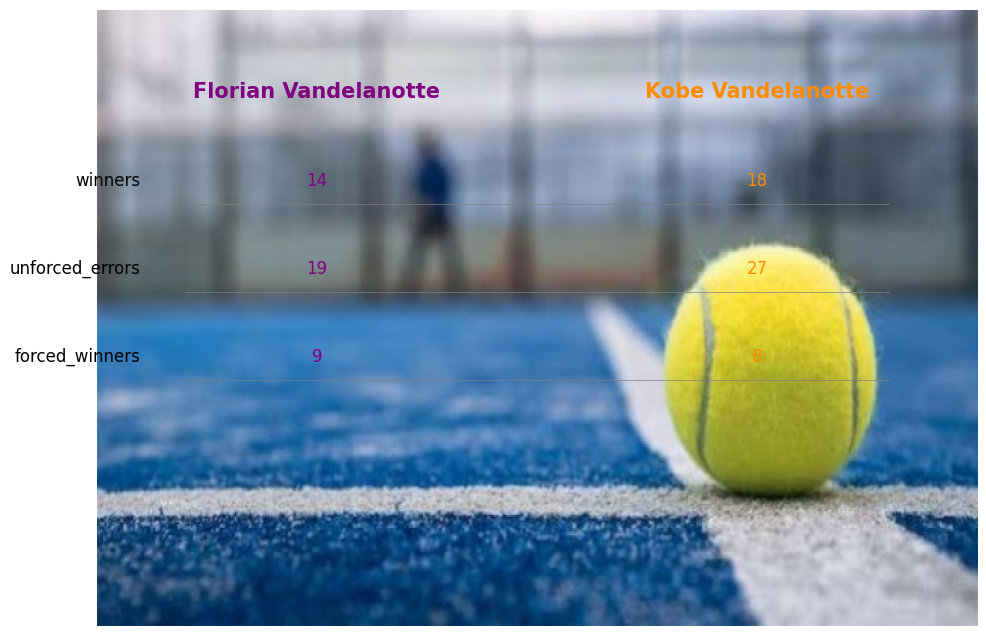

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_comparison(data: dict, background_image_path: str):
   # Load the background image
    img = plt.imread(background_image_path)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Display the image on the plot
    ax.imshow(img, extent=[0, 10, 0, 7])
    
    categories = list(data['player1_stats'].keys())
    player1_scores = list(data['player1_stats'].values())
    player2_scores = list(data['player2_stats'].values())

    # Annotate the player names
    ax.text(2.5, 6, data['player1_name'], color='purple', size=15, weight='bold', ha='center')
    ax.text(7.5, 6, data['player2_name'], color='darkorange', size=15, weight='bold', ha='center')
    
    for idx, cat in enumerate(categories):
        y_pos = 5 - idx  # Vertically position categories and scores
        
        # Draw horizontal line for clarity
        ax.axhline(y_pos - 0.2, color='gray', linewidth=0.5, xmin=0.1, xmax=0.9)

        ax.text(0.5, y_pos, cat, color='black', size=12, ha='right')  # Category name
        ax.text(2.5, y_pos, str(player1_scores[idx]), color='purple', size=12, ha='center')  # Player1 score
        ax.text(7.5, y_pos, str(player2_scores[idx]), color='darkorange', size=12, ha='center')  # Player2 score
        
    # Remove x and y ticks, and set the x and y limits to fit the background
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 7)
    ax.axis('off')  # Turn off the axis

    plt.tight_layout()
    plt.show()

# Example usage
data = db.compare_players_in_match("Florian Vandelanotte", "Kobe Vandelanotte", 2)
visualize_comparison(data, "visualisation_bg.jpg")
